First, let's import `mujoco` and some other useful libraries.

In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
from callbacks import *
from scipy.spatial.transform import Rotation as R

We will now set our model path, and ask MuJoCo to setup the following:

* MuJoCo's `mjModel` contains the _model description_, i.e., all quantities that *do not change over time*. 
* `mjData` contains the state and the quantities that depend on it. In order to make an `mjData`, we need an `mjModel`. `mjData` also contains useful functions of the state, for e.g., the Cartesian positions of objects in the world frame.
* `mjvCamera` and `mjvOption` are for visualization. We don't have to worry about this for now.

In [2]:
xml_path = 'models/mushr.xml' #xml file (assumes this is in the same folder as this file)
view = "first"
assert view in ["first","third"]
simend = 600

# MuJoCo data structures
model = mj.MjModel.from_xml_path(xml_path)  # MuJoCo model
data  = mj.MjData(model)                    # MuJoCo data
cam   = mj.MjvCamera()                        # Abstract camera
opt   = mj.MjvOption()                        # visualization options

Next, we set up the visualization code. You don't have to change any of this code for Assignment 0.

In [3]:
# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(800, 600, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

cb = Callbacks(model,data,cam,scene)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, cb.keyboard)
glfw.set_cursor_pos_callback(window, cb.mouse_move)
glfw.set_mouse_button_callback(window, cb.mouse_button)
glfw.set_scroll_callback(window, cb.scroll)

# Example on how to set camera configuration
cam.azimuth = -90 ; cam.elevation = -45 ; cam.distance =  13
cam.lookat =np.array([ 0.0 , 0.0 , 0.0 ])

Now let's do something with our differential drive car. Our car has two actuators that control the velocity of the wheels. We can directly command these actuators to achieve a particular velocity by accessing `data.ctrl` variable. For a simple controller, like the one we'll be using in this notebook, this is fine. But for a more complicated controller, this will make our main simulation loop very clunky.

Thankfully, MuJoCo lets us use a control _callback_ using the `set_mjcb_control` method. A callback function is a function passed into another function as an argument, which is then invoked inside the outer function to complete some kind of routine or action.

This way, we can define our controller outside the main simulation loop, and then MuJoCo will call it automatically!

In [4]:
class Controller:
    def __init__(self,model,data):
        # Initialize the controller here.
        pass
    
    def controller(self,model,data):
        data.ctrl[0] = 0.25
        data.ctrl[1] = 2.0

c = Controller(model,data)
mj.set_mjcb_control(c.controller)

The below while loop will continue executing for `simend` seconds, where `simend` is the end time we defined above. MuJoCo lets us keep track of the total elapsed time using the `data.time` variable.

At a frequency of ~60Hz, it will step forward the simulation using the `mj_step` function. A more detailed explanation of what happens when you call `mj_step` is given [here](https://mujoco.readthedocs.io/en/latest/computation.html?highlight=mj_step#forward-dynamics). But for the sake of simplicity, you can asume that it applies the controls to the actuator, calculates the resulting forces, and computes the result of the dynamics.  

In [5]:
def in_collision():
    buddy_pos = data.site_xpos[0]
    human_pos = data.site_xpos[1]
    distance = (np.linalg.norm(buddy_pos - human_pos))
    # print(distance)
    #Explanation of 0.65224 given below
    if distance <= 0.62524:
        return True
    return False
    

To find out if the two bodies are colliding, we calculate the distances between the Human Body and the Buddy Car. If that distance is within a threshold we say that it is a collision. 

Given positions in the XML for Buddy Car tires are : <b>FL(0.1385 0.115 0.0488), FR(0.1385 -0.115 0.0488), BR(-0.158 -0.115 0.0488) and BL(-0.158 0.115 0.0488)</b>. We aproximate this Buddy car as a cuboid of dimensions corresponding to the coordinates of the tires. The dimentions of the cuboid will come out to be: 

The human body is considered to be cylinder with <b>radius = 0.25 and height = 0.33</b>. 

Site_XPOS will give us the centre point of the bodies. 

To calculate the threshold, we calculate the distance of the point furthest away from the centre for both the bodies. For the car, we approximate it to be the point which is <b>diagonally opposite to the centre i.e. 0.37524 units away</b>. For the human body, the distance will be the <b>radius of the cylinder i.e. 0.25 units</b>. Whenever the body and the buddy car approach each other the distances between the centre decrease and the maximum distance for which the collision might occur will be the <b>sum of the distances of the points that are furthest away from the centre</b>. Which in this case comes out to be <b>0.62524</b>.

Here, only the position of the body and buddy car in the XY-plane matter when we think about collision. Hence, we are calculating distances considering only the XY coordinates.

Also, since we are consiering the maximum distance at which the collision might occur, there might be some false positive cases when the centre of the body reaches a distance of 0.62524 away from the centre of the buddy car.


In [6]:
trajectory1 = []
trajectory2 = []
collide = 0
while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model,data)
        if(in_collision()):
            collide = 1
            break
        trajectory1.append(np.copy(data.qpos))
        trajectory2.append(np.copy(data.site_xpos[1]))
        if view == "first":
            cam.lookat[0] = data.site_xpos[1][0]
            cam.lookat[1] = data.site_xpos[1][1]
            cam.lookat[2] = data.site_xpos[1][2] + 0.5
            cam.elevation = 0.0
            cam.distance = 1.0
    if collide == 1:
        break
        
    if data.time >= simend:
        break

    # ==================================================================================
    # The below code updates the visualization -- do not modify it!
    # ==================================================================================
    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()
    

glfw.terminate()

(312, 14)
(312, 3)


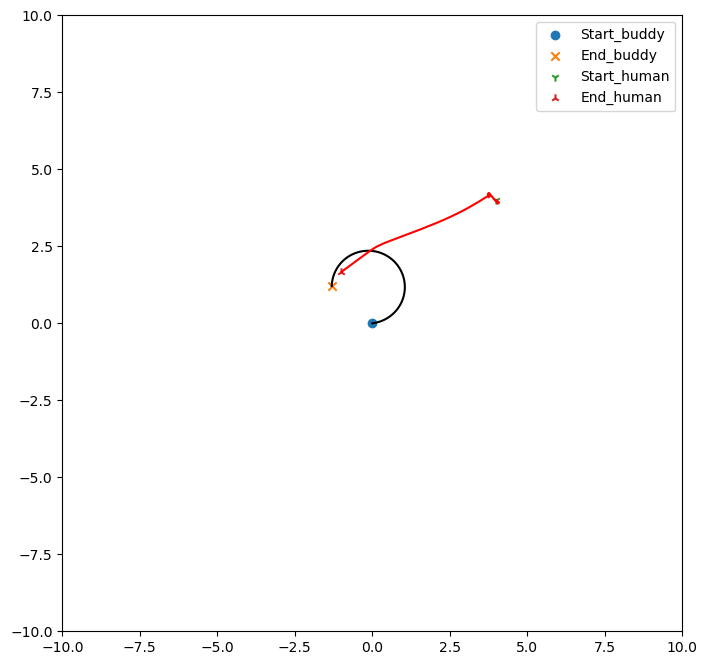

In [7]:
import matplotlib.pyplot as plt
# You need the below line only if you're using this inside a Jupyter notebook.
%matplotlib inline

trajectory1 = np.array(trajectory1)
trajectory2 = np.array(trajectory2)
print(trajectory1.shape)
print(trajectory2.shape)

plt.figure(figsize=(8,8))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.plot(trajectory1[:,0],trajectory1[:,1],color='black')
plt.plot(trajectory2[:,0],trajectory2[:,1],color='red')

plt.scatter(trajectory1[0,0],trajectory1[0,1],marker='o',label='Start_buddy')
plt.scatter(trajectory1[-1,0],trajectory1[-1,1],marker='x',label='End_buddy')

plt.scatter(trajectory2[0,0],trajectory2[0,1],marker='1',label='Start_human')
plt.scatter(trajectory2[-1,0],trajectory2[-1,1],marker='2',label='End_human')
plt.legend(loc='best')
plt.show()